# Tutorial: Recursive Language Models (RLM)

This tutorial demonstrates **Recursive Language Models (RLM)**, an inference strategy where LLMs treat long contexts as part of an external environment rather than feeding them directly to the model. The LLM writes Python code to programmatically examine, decompose, and recursively call sub-LLMs over snippets.

Reference: ["Recursive Language Models" (Zhang, Kraska, Khattab, 2025)](https://arxiv.org/abs/placeholder)

We'll evaluate RLM on the [Oolong benchmark](https://huggingface.co/datasets/oolongbench/oolong-synth), which tests long context reasoning and aggregation capabilities.

Install dependencies: `pip install dspy datasets`

## Setup

Configure DSPy with an LLM. RLM uses this LLM both for generating code and for the `llm_query()` tool inside the sandbox.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dspy

lm = dspy.LM("openai/gpt-5")
dspy.configure(lm=lm)

/Users/isaac/Projects/dspy-worktrees/isaac/isaac/dspy-rlm/.venv/lib/python3.14/site-packages/openai/_compat.py:48: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.typing import (


In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')


## Load the Oolong Dataset

Oolong is a benchmark for evaluating long context reasoning and aggregation. Tasks include counting labels, finding needles in haystacks, and comparing frequencies.

The dataset has two splits with different source datasets:
- **validation** (1,300 examples): `spam` (650), `trec_coarse` (650)
- **test** (5,200 examples): `agnews`, `app_reviews`, `formality`, `imdb`, `metaphors`, `multinli`, `negation`, `yahoo` (650 each)

In [4]:
from datasets import load_dataset
from collections import Counter

# Load both splits
dataset = load_dataset("oolongbench/oolong-synth")
val_data = dataset["validation"]
test_data = dataset["test"]

print(f"Validation: {len(val_data)} examples")
print(f"  Datasets: {dict(Counter(val_data['dataset']))}")

print(f"\nTest: {len(test_data)} examples")
print(f"  Datasets: {dict(Counter(test_data['dataset']))}")

Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

Validation: 1300 examples
  Datasets: {'spam': 650, 'trec_coarse': 650}

Test: 5200 examples
  Datasets: {'metaphors': 650, 'negation': 650, 'formality': 650, 'imdb': 650, 'app_reviews': 650, 'yahoo': 650, 'multinli': 650, 'agnews': 650}


## Prepare Examples for Evaluation

Convert the dataset to `dspy.Example` format, organized by source dataset.

In [5]:
import random
random.seed(42)

def make_example(row):
    return dspy.Example(
        id=row["id"],
        context_window_id=row.get("context_window_id"),
        context=row["context_window_text"],
        query=row["question"],
        answer=row["answer"],
        task=row.get("task", "unknown"),
        answer_type=row.get("answer_type", "LABEL"),
        dataset=row.get("dataset", "unknown"),
        context_len=row.get("context_len", len(row["context_window_text"])),
    ).with_inputs("context", "query")

# Separate validation by source dataset
val_spam = [make_example(row) for row in val_data if row["dataset"] == "spam"]
val_trec = [make_example(row) for row in val_data if row["dataset"] == "trec_coarse"]

# IMPORTANT: Shuffle before splitting! The dataset is ordered by context_len,
# so without shuffling, devset would only contain the shortest (easiest) examples.
random.shuffle(val_spam)
random.shuffle(val_trec)

# For each validation dataset: first 50 as dev, rest as val
devset_spam, valset_spam = val_spam[:50], val_spam[50:]
devset_trec, valset_trec = val_trec[:50], val_trec[50:]

# Combined devset and valset
devset = devset_spam + devset_trec
valset = valset_spam + valset_trec

# Separate test by source dataset
test_by_dataset = {}
for row in test_data:
    ds_name = row["dataset"]
    if ds_name not in test_by_dataset:
        test_by_dataset[ds_name] = []
    test_by_dataset[ds_name].append(make_example(row))

# Full testset (also shuffle for fair sampling)
testset = [make_example(row) for row in test_data]
random.shuffle(testset)

print("Validation splits (shuffled by context_len):")
print(f"  devset_spam: {len(devset_spam)}, valset_spam: {len(valset_spam)}")
print(f"  devset_trec: {len(devset_trec)}, valset_trec: {len(valset_trec)}")
print(f"  devset (combined): {len(devset)}, valset (combined): {len(valset)}")

# Show context_len distribution in devset to verify shuffling worked
from collections import Counter
devset_lens = Counter(ex.context_len for ex in devset)
print(f"\n  devset context_len distribution: {dict(sorted(devset_lens.items()))}")

print(f"\nTest splits:")
for name, examples in sorted(test_by_dataset.items()):
    print(f"  {name}: {len(examples)}")
print(f"  testset (combined): {len(testset)}")

Validation splits (shuffled by context_len):
  devset_spam: 50, valset_spam: 600
  devset_trec: 50, valset_trec: 600
  devset (combined): 100, valset (combined): 1200

  devset context_len distribution: {1024: 11, 2048: 9, 4096: 9, 8192: 9, 16384: 8, 32768: 3, 65536: 10, 131072: 4, 262144: 13, 524288: 7, 1048576: 7, 2097152: 4, 4194304: 6}

Test splits:
  agnews: 650
  app_reviews: 650
  formality: 650
  imdb: 650
  metaphors: 650
  multinli: 650
  negation: 650
  yahoo: 650
  testset (combined): 5200


## Define the Metric

The metric matches the [official Oolong benchmark evaluation](https://github.com/abertsch72/oolong/blob/main/src/eval/eval_helpers.py):
- Parses answers by taking text after the last `:`
- Exact string matching for labels
- Partial credit for numeric answers: `0.75 ** abs(gold - predicted)`
- Special handling for comparison answers ("more common", "less common", "same frequency")

In [6]:
import re
import ast

def parse_answer(answer: str) -> tuple[str, str]:
    """Parse model answer, returning (parsed_answer, confidence).
    
    Matches the official Oolong benchmark parsing logic.
    """
    parse_confidence = "low"
    
    if ":" not in answer:
        if len(answer) < 20:
            return answer, parse_confidence
        else:
            return answer.split()[-1], parse_confidence
    
    # Take text after last ":"
    candidate = answer.split(":")[-1].strip()
    
    # Remove markdown bolding and brackets
    candidate = candidate.replace("*", "")
    candidate = candidate.replace("[", "").replace("]", "")
    
    parse_confidence = "med"
    
    # Higher confidence if answer follows expected format
    if any(marker in answer for marker in ["User:", "Answer:", "Date:", "Label"]):
        parse_confidence = "high"
    
    if len(candidate) < 20:
        parse_confidence = "vhigh"
    elif "more common" in candidate:
        candidate = "more common"
    elif "less common" in candidate:
        candidate = "less common"
    elif "same frequency" in candidate:
        candidate = "same frequency"
    
    return candidate, parse_confidence


def oolong_metric(example, pred, trace=None):
    """Official Oolong benchmark metric with partial credit for numeric answers."""
    
    # Parse gold answer
    expected = example.answer
    if isinstance(expected, list):
        gold = str(expected[0])
    else:
        expected_str = str(expected).strip()
        if expected_str.startswith("[") and expected_str.endswith("]"):
            try:
                parsed = ast.literal_eval(expected_str)
                gold = str(parsed[0]) if isinstance(parsed, list) else expected_str
            except:
                gold = expected_str
        else:
            gold = expected_str
    
    # Parse model answer
    trimmed_output, _ = parse_answer(pred.answer)
    
    # Exact match
    if str(trimmed_output).strip().lower() == str(gold).strip().lower():
        return 1.0
    
    # Comparison answers (more/less/same common)
    if trimmed_output in ["more common", "less common", "same frequency"]:
        if trimmed_output in str(gold).lower():
            return 1.0
    
    # Numeric: partial credit with exponential decay
    answer_type = getattr(example, "answer_type", "")
    if answer_type == "ANSWER_TYPE.NUMERIC" or answer_type == "NUMERIC":
        try:
            pred_num = int(trimmed_output)
            gold_num = int(gold)
            return 0.75 ** abs(gold_num - pred_num)
        except (ValueError, TypeError):
            pass
    
    return 0.0

## Initialize RLM

RLM executes in a secure Deno/Pyodide/WASM sandbox. The LLM can:
- Access the `context` variable containing the input data
- Call `llm_query(prompt)` to query a sub-LLM for semantic analysis
- Use standard Python libraries (re, json, collections, etc.)
- Build up answers iteratively through multiple code executions

In [7]:
def llm_query_nano(prompt: str = "") -> str:
    """Query gpt-5-nano with a prompt."""
    if not prompt:
        raise ValueError("prompt is required")
    nano = dspy.LM("openai/gpt-5-nano")
    response = nano(prompt)
    return response[0] if isinstance(response, list) else str(response)

In [8]:
from dspy.predict.rlm import RLM

rlm = RLM("context, query -> answer", max_iterations=20, sub_lm=dspy.LM("openai/gpt-5-nano"), verbose=True)

## Run Evaluation on Devset

Use `dspy.Evaluate` to run RLM on the devset with parallelism. For full evaluation, replace `devset` with `valset` or `testset`.

In [ ]:
# Available splits: devset_spam, devset_trec, valset_spam, valset_trec, test_by_dataset[name], testset
dspy.configure(lm=dspy.LM("openai/gpt-5"))

# Use the pre-shuffled devset (now includes mixed context lengths)
current_devset = devset_trec[:20]

evaluate = dspy.Evaluate(
    devset=current_devset,
    metric=oolong_metric,
    num_threads=10,
    display_progress=True,
    display_table=10,
    provide_traceback=True,
)

results = evaluate(rlm)

# Show results with context_len breakdown
print("\nOolong RLM Evaluation Results:")
print(f"Split: devset_trec (shuffled), {len(current_devset)} examples")
print(f"  LLM: {dspy.settings.lm.model}")
print(f"  Alex RLM: 56.5%")
print(f"  DSPy RLM: {results.score:.2f}%")

avg_trajectory_length = sum(len(r[1].trajectory) for r in results.results) / len(results.results)
print(f"  Avg trajectory length: {avg_trajectory_length:.2f}")

  0%|          | 0/20 [00:00<?, ?it/s]

2026/01/07 15:22:31 INFO dspy.predict.rlm: RLM iteration 1/20
Reasoning: STEP 1 - EXPLORE: I'll inspect the context and query by printing their lengths, a preview, and basic structure (like number of lines). I will not compute any labels or answers yet.
Code:
# Step 1: Explore the input data (no answering yet)

# Basic lengths
print("Context length (chars):", len(context))
print("Query length (chars):", len(query))

# Preview of context
print("\n--- Context preview (first 600 chars) ---")
print(context[:600])

# Show number of lines and a few sample lines
ctx_lines = context.splitlines()
print("\nTotal context lines:", len(ctx_lines))
print("\n--- First 10 lines ---")
for i, line in enumerate(ctx_lines[:10], 1):
    print(f"{i:02d}: {line}")

print("\n--- Last 10 lines ---")
for i, line in enumerate(ctx_lines[-10:], len(ctx_lines)-9):
    print(f"{i:02d}: {line}")

# Show query content
print("\n--- Query ---")
print(query)
2026/01/07 15:22:33 INFO dspy.predict.rlm: RLM iteration 1/20
R

Average Metric: 0.00 / 1 (0.0%):   5%|▌         | 1/20 [01:16<24:05, 76.08s/it]

2026/01/07 15:23:37 INFO dspy.predict.rlm: RLM iteration 2/20
Reasoning: STEP 2 - ANALYZE: I will extract the 14 questions from context, ask the sub-LLM once to classify each into one of the 6 given categories using the exact label strings, parse the JSON response, and count how many are labeled 'description and abstract concept'. I will store and print the classifications and the computed count for verification.
Code:
import re, json

# Extract questions
questions = re.findall(r'Instance:\s*(.+?)\s*$', context, flags=re.MULTILINE)
print("Found questions:", len(questions))
for i, q in enumerate(questions, 1):
    print(f"{i:02d}: {q}")

# Build prompt for a single batched classification
prompt = f"""
You are given 14 questions. For each, assign exactly one label from this exact set:
- 'abbreviation'
- 'entity'
- 'human being'
- 'numeric value'
- 'location'
- 'description and abstract concept'

Return a JSON array of 14 objects, each with fields:
- "index": 1-based index (1..14) matchin

Average Metric: 1.00 / 2 (50.0%):  10%|█         | 2/20 [02:19<20:35, 68.65s/it]

2026/01/07 15:24:37 INFO dspy.predict.rlm: RLM iteration 2/20
Reasoning: STEP 1 was completed previously: we explored the context and confirmed there are 102,166 lines, with 102,158 question lines from line 5 to 102,162 inclusive.

Plan for STEP 2:
- Parse all question lines that match the "Date: ... || User: ... || Instance: ..." pattern and extract just the question text.
- Split these questions into chunks targeting ~400k characters per chunk to stay under the ~500k limit per llm_query call.
- For each chunk, call llm_query with a strict prompt to classify all questions into the six labels and return counts as strict JSON with all six keys. We'll verify that the counts per chunk sum exactly to the number of questions in that chunk. If parsing fails or sum mismatches, retry once with a stricter prompt.
- Aggregate counts across all chunks, then compute and store the totals for 'location' and 'human being'.
- STEP 3: Print the final comparison string for verification.
- STEP 4: Submit

Average Metric: 2.00 / 3 (66.7%):  15%|█▌        | 3/20 [02:30<11:59, 42.30s/it]

2026/01/07 15:24:50 INFO dspy.predict.rlm: RLM iteration 2/20
Reasoning: Plan:
- STEP 2 - ANALYZE: Parse all 89 question lines from context. Use regex-based heuristics to classify only two labels we care about: 'abbreviation' and 'numeric value'. Everything else is ignored for counting purposes. Compute exact counts of the two labels and compare.
- STEP 3 - VERIFY: Print the counts and the comparison phrase to ensure correctness.
- STEP 4 - SUBMIT: Return final formatted answer as requested.

Heuristics:
- abbreviation if question contains phrases like "stand for", "abbreviation for", "abbreviate", "initials of", "acronym for".
- numeric value if question starts with "How many", "How much", "How far", "How long", "How old", "How tall", "How big", or contains "What percent", "What percentage", "When", "What are the highest-paying odds", etc.
- Only counting for these two categories.
Code:
# STEP 2 - ANALYZE

import re

# Extract question lines
lines = context.splitlines()
q_re = re.comp

Average Metric: 3.00 / 4 (75.0%):  20%|██        | 4/20 [03:18<11:51, 44.44s/it]

2026/01/07 15:25:36 INFO dspy.predict.rlm: RLM iteration 2/20
Reasoning: STEP 2 - ANALYZE: I will parse out the 6,374 question lines (after "|| Instance:") and classify each into one of the six labels using deterministic regex/string rules modeled on coarse TREC question classes:
- abbreviation: contains “stand for”, “abbreviation”, “acronym”, “short for”, “full name/form”, “initials/initialism”, or “what does … mean” when the term looks like an acronym (ALLCAPS or dotted like U.S.S.R.).
- human being: starts with who/whom/whose, or patterns like “which/what … [human role]”, or “what is the name of … [human role]”.
- location: starts with where, or patterns with “what/which/in what … (city|state|country|capital|river|lake|mountain|island|ocean|sea|continent|province|county|valley|desert|peninsula)”, or “capital of”.
- numeric value: starts with when, or “how many/much/old/tall/long/high/far/fast/big/heavy/deep/wide/large/often”, or contains “what year/date/time/percent/percentage/numbe

Average Metric: 3.00 / 5 (60.0%):  25%|██▌       | 5/20 [03:30<08:15, 33.01s/it]

2026/01/07 15:25:53 INFO dspy.predict.rlm: RLM iteration 1/20
Reasoning: Step 1 - Explore: I will inspect the overall size and print a small sample of the context, plus the first few lines and basic line counts to understand the data structure before attempting to answer.
Code:
# STEP 1 - EXPLORE

# Basic exploration: length, beginning snippet, first few lines, and line count
print("Total length of context:", len(context))

# Show the first 600 characters to see header/format
print("\n=== Head snippet (600 chars) ===\n")
print(context[:600])

# Split into lines to inspect structure
lines = context.splitlines()
print("\nTotal lines (splitlines):", len(lines))

# Show the first 15 non-empty lines to understand formatting
non_empty = [ln for ln in lines if ln.strip()]
print("\n=== First 15 non-empty lines ===")
for i, ln in enumerate(non_empty[:15], 1):
    print(f"{i:02d}: {ln}")

# Try to find a few lines containing '30979' to see field layout
matches_30979_idx = [i for i, ln in enumera

Average Metric: 4.00 / 6 (66.7%):  30%|███       | 6/20 [04:17<08:48, 37.76s/it]

2026/01/07 15:26:41 INFO dspy.predict.rlm: RLM iteration 6/20
Reasoning: We need exact label counts for user 84905. Earlier attempts showed 15 instances for that user but didn’t find explicit label keys; naive scans for label terms matched question text (e.g., “abbreviation” inside questions). To get exact labels, we likely need to locate a separate label section, possibly encoded with short codes (TREC coarse labels: ABBR, HUM, ENTY, DESC, LOC, NUM) or as lines containing the full terms but with numbering or simple formatting.

Plan:
- Confirm total instance lines (should be 6374).
- Search for label encodings:
  - Short codes ABBR/HUM/ENTY/DESC/LOC/NUM.
  - Keywords category/type/class/label in any case.
  - Lines that, after stripping numbering/punctuation, equal one of the six full label terms.
- If a contiguous or indexed label list of length 6374 exists, align it by order with instance lines and extract labels for user 84905 positions.
- If not contiguous but appears as codes int

Average Metric: 5.00 / 7 (71.4%):  35%|███▌      | 7/20 [04:49<07:45, 35.79s/it]

2026/01/07 15:27:14 INFO dspy.predict.rlm: RLM iteration 6/20
Reasoning: I already completed Steps 1–3:
- Extracted all 14 questions for User 64959 from context.
- Used a single llm_query to classify each into one of the six categories.
- Verified counts among this subset: entity = 3, description and abstract concept = 1.
Thus, entity is more common.

Proceeding to Step 4 to submit the final answer.
Code:
FINAL("Answer: entity is more common than description and abstract concept")


Average Metric: 6.00 / 8 (75.0%):  40%|████      | 8/20 [04:57<05:22, 26.85s/it]

2026/01/07 15:27:23 INFO dspy.predict.rlm: RLM iteration 2/20
Reasoning: STEP 2 - ANALYZE: I will extract all 39 "Instance:" questions from context, then classify each into one of the six categories using pattern rules to count how many are 'description and abstract concept' vs 'human being'. Then compare their frequencies.
Code:
# STEP 2 - ANALYZE

import re

# Extract all Instance questions
lines = context.splitlines()
instances = []
for ln in lines:
    m = re.search(r'Instance:\s*(.+?)\s*$', ln)
    if m:
        instances.append(m.group(1).strip())

print("Total extracted instances:", len(instances))
for i, q in enumerate(instances):
    print(f"{i+1:02d}. {q}")

# Classification rules for the 6 categories:
# - 'human being' (HUM): questions seeking a person/people (Who ...?), or 'What [role/people]' where the expected answer is names of people (e.g., "What attorneys ...").
# - 'description and abstract concept' (DESC): definitions, meanings, causes, reasons, explanations ("What i

Average Metric: 7.00 / 9 (77.8%):  45%|████▌     | 9/20 [05:12<04:14, 23.10s/it]

2026/01/07 15:27:38 INFO dspy.predict.rlm: RLM iteration 1/20
Reasoning: Step 1 - EXPLORE: I will inspect the context structure: overall length, count of lines, and print a small sample from the start and also search for occurrences of label names and user-id-like patterns to understand how records are formatted.
Code:
# Step 1 - EXPLORE

# Basic structure and size
print("Context length:", len(context))
print("Query length:", len(query))

# Show the first 1500 characters to understand header and formatting
print("Context head sample:")
print(context[:1500])

# Count lines and show first few non-header lines
lines = context.splitlines()
print("Total lines:", len(lines))
print("First 30 lines:")
for i, line in enumerate(lines[:30]):
    print(f"{i:02d}: {line}")

# Look for where the actual 6374 lines start:
# Find the first line that looks like a data record by heuristics:
# - contains one of the 6 labels
labels = [
    'numeric value',
    'human being',
    'entity',
    'description 

Average Metric: 8.00 / 10 (80.0%):  50%|█████     | 10/20 [05:28<03:29, 20.99s/it]

2026/01/07 15:27:52 INFO dspy.predict.rlm: RLM iteration 1/20
Reasoning: STEP 1 - EXPLORE: I will inspect the structure of the `context` string: its length, number of lines, and print head/tail samples and a few initial lines to understand how labels are represented before attempting any counting.
Code:
# STEP 1 - EXPLORE

# Print basic structure information
print("Context length:", len(context))
lines = context.splitlines()
print("Total lines:", len(lines))

# Show a head and tail sample
print("\n--- HEAD (first 500 chars) ---\n", context[:500])
print("\n--- TAIL (last 500 chars) ---\n", context[-500:])

# Show first 30 non-empty lines to observe formatting
non_empty_lines = [ln for ln in lines if ln.strip()]
print("\n--- First 30 non-empty lines ---")
for i, ln in enumerate(non_empty_lines[:30], 1):
    print(f"{i:02d}: {ln}")

# Try to find if keywords like 'label', 'category', or the six category names appear
keywords = ["label", "category", "categories", "numeric value", "human be

Average Metric: 9.00 / 11 (81.8%):  55%|█████▌    | 11/20 [05:41<02:47, 18.61s/it]

2026/01/07 15:28:00 INFO dspy.predict.rlm: RLM iteration 3/20
Reasoning: STEP 2 - ANALYZE: The prior heuristic classification may be inaccurate (e.g., “What is Li'l Abner's last name?” isn’t a description). I will use a single semantic LLM call to label each of the 39 questions into one of the six categories, then count 'description and abstract concept' vs 'human being' and compare.

STEP 3 - VERIFY: I will print the labeled results, the counts, and the final comparison string to verify correctness before submitting.
Code:
# STEP 2 - ANALYZE (refined with semantic labeling)

import json
import re

# Extract all Instance questions
lines = context.splitlines()
instances = []
for ln in lines:
    m = re.search(r'Instance:\s*(.+?)\s*$', ln)
    if m:
        instances.append(m.group(1).strip())

print("Total extracted instances:", len(instances))
for i, q in enumerate(instances, 1):
    print(f"{i:02d}. {q}")

allowed_labels = [
    "description and abstract concept",
    "entity",
    "l

Average Metric: 9.00 / 12 (75.0%):  60%|██████    | 12/20 [06:03<02:37, 19.72s/it]

2026/01/07 15:28:35 INFO dspy.predict.rlm: RLM iteration 2/20
Reasoning: Step 2 - ANALYZE: I need to determine if labels are present in the context. I will search for any explicit label markers (HUM/ENTY/LOC/NUM/DESC/ABBR or spelled-out names), fields like "|| Label:", and confirm how many example lines begin with "Date:". If labels are not present, I will need to consider whether there's any embedded structure to derive them exactly; otherwise, I must look for any hidden labeling cues. I’ll print findings and small samples.
Code:
# Step 2 - ANALYZE

import re
from collections import Counter

print("Count of lines starting with 'Date:':", sum(1 for l in context.splitlines() if l.startswith("Date:")))
print("Unique prefixes (first 6 chars) and counts (top 10):")
pref = Counter(l[:6] for l in context.splitlines())
for p, c in pref.most_common(10):
    print(p, c)

lines = context.splitlines()

# Search for explicit label markers
patterns = {
    "HUM_code": re.compile(r'\bHUM\b'),
    "E

Average Metric: 10.00 / 13 (76.9%):  65%|██████▌   | 13/20 [06:49<03:13, 27.61s/it]

2026/01/07 15:29:07 INFO dspy.predict.rlm: RLM iteration 2/20
Reasoning: STEP 2: Parse the 14 question lines from context, then deterministically identify which questions correspond to 'numeric value' and which to 'description and abstract concept' using clear keyword rules specific to these items (no LLM needed). Count each and compare. Then verify by printing the derived questions and counts before submitting.
Code:
# STEP 2 - ANALYZE

import re

# Extract all question instances
lines = context.splitlines()
questions = []
for line in lines:
    m = re.search(r'Instance:\s*(.+?)\s*$', line)
    if m:
        questions.append(m.group(1))

print("Total extracted questions:", len(questions))
for i, q in enumerate(questions, 1):
    print(f"{i:02d}. {q}")

# Define deterministic rules to identify numeric and description questions in this dataset
def is_numeric(q):
    ql = q.lower().strip()
    if ql.startswith("how many"):
        return True
    if "regular price" in ql:
        return 

Average Metric: 10.00 / 14 (71.4%):  70%|███████   | 14/20 [06:51<01:58, 19.68s/it]

2026/01/07 15:29:17 INFO dspy.predict.rlm: RLM iteration 4/20
Reasoning: We extracted 39 questions and used a single semantic labeling call to assign one of the six categories to each. From the labeled results, we counted 'description and abstract concept' vs 'human being'. The counts showed 'description and abstract concept' > 'human being', and we printed the proposed final statement to verify formatting. Proceeding to submit.
Code:
FINAL("Answer: description and abstract concept is more common than human being")


Average Metric: 11.00 / 16 (68.8%):  80%|████████  | 16/20 [07:06<00:53, 13.29s/it]

2026/01/07 15:29:26 INFO dspy.predict.rlm: RLM iteration 4/20
Reasoning: STEP 1 - EXPLORE: We inspected the dataset structure and confirmed lines are formatted like "Date: ... || User: ... || Instance: ...". There is no explicit "Label:" field in the lines. We found 15 instances associated with user ID 84905, but we did not yet extract labels. 

STEP 2 - ANALYZE: Plan:
- Extract the 15 questions for User: 84905.
- Use llm_query_batched to classify each question into one of the six categories: 'numeric value', 'human being', 'entity', 'description and abstract concept', 'location', 'abbreviation'. In the prompt, request the model to output exactly one of these labels.
- Parse responses, tally counts for 'human being' and 'description and abstract concept'.
- Decide the relation ("more common than", "less common than", or "same frequency as") and build the final answer string.

STEP 3 - VERIFY: Print extracted questions, predicted labels, and counts to ensure correctness.

STEP 4 - SUBMI

Average Metric: 11.00 / 17 (64.7%):  85%|████████▌ | 17/20 [07:36<00:55, 18.51s/it]

2026/01/07 15:29:53 INFO dspy.predict.rlm: RLM iteration 1/20
Reasoning: STEP 1 - EXPLORE: I will inspect the structure of the `context` string: its length, number of lines, and print head/tail samples and a few initial lines to understand how labels are represented before attempting any counting.
Code:
# STEP 1 - EXPLORE

# Print basic structure information
print("Context length:", len(context))
lines = context.splitlines()
print("Total lines:", len(lines))

# Show a head and tail sample
print("\n--- HEAD (first 500 chars) ---\n", context[:500])
print("\n--- TAIL (last 500 chars) ---\n", context[-500:])

# Show first 30 non-empty lines to observe formatting
non_empty_lines = [ln for ln in lines if ln.strip()]
print("\n--- First 30 non-empty lines ---")
for i, ln in enumerate(non_empty_lines[:30], 1):
    print(f"{i:02d}: {ln}")

# Try to find if keywords like 'label', 'category', or the six category names appear
keywords = ["label", "category", "categories", "numeric value", "human be

Average Metric: 11.00 / 18 (61.1%):  90%|█████████ | 18/20 [08:24<00:54, 27.30s/it]

2026/01/07 15:31:03 INFO dspy.predict.rlm: RLM iteration 4/20
Reasoning: We already explored the data and extracted 787 questions. An initial single-call classification labeled 715 items, leaving 72 missing, but showed "description and abstract concept" far greater than "entity". To ensure exact counts, I will re-run classification in smaller batches using llm_query_batched, parse strictly, retry any missing indices with smaller batches, and finally compute the counts and the relation. I will then verify by printing counts and the final formatted answer before submitting.
Code:
# STEP 2 - ANALYZE (robust batched classification with retries)

import re
from collections import Counter

# Extract questions again
lines = context.splitlines()
questions = []
pattern = re.compile(r'\bInstance:\s*(.*)')
for line in lines:
    m = pattern.search(line)
    if m:
        q = m.group(1).strip()
        q = re.sub(r'\s+', ' ', q)
        questions.append(q)

print("Total questions extracted:", len(

Average Metric: 12.00 / 19 (63.2%): 100%|██████████| 20/20 [09:25<00:00, 27.07s/it]

2026/01/07 15:31:42 INFO dspy.predict.rlm: RLM iteration 4/20
Reasoning: We already explored the inputs and extracted 787 questions. A first single-call classification labeled only 715, leaving 72 unlabeled. I will re-run classification in smaller batches using llm_query_batched, parse robustly, retry missing indices in smaller batches, and finally individually if needed. Then I will print the counts and the relation for verification. I will not submit the final answer in this step.
Code:
# STEP 2/3 - ANALYZE and VERIFY

import re
from collections import Counter

# Extract questions
lines = context.splitlines()
questions = []
pattern = re.compile(r'\bInstance:\s*(.*)')
for line in lines:
    m = pattern.search(line)
    if m:
        q = m.group(1).strip()
        q = re.sub(r'\s+', ' ', q)
        questions.append(q)

print("Total questions extracted:", len(questions))
assert len(questions) == 787, f"Expected 787 questions, got {len(questions)}"

allowed_labels = {
    "location": "lo

Average Metric: 12.00 / 19 (63.2%): : 21it [09:27, 19.50s/it]                      

2026/01/07 15:31:44 INFO dspy.predict.rlm: RLM iteration 5/20
Reasoning: Plan: Continue STEP 2 - ANALYZE robustly. I will:
- Re-extract all 787 questions.
- Classify them in manageable batches using llm_query (since llm_query_batched caused an error).
- Parse outputs, retry missing indices with smaller batch sizes until all are labeled.
- Count labels and print the relation between "description and abstract concept" and "entity" for verification (STEP 3).
I will not submit FINAL in this step.
Code:
# STEP 2 - ANALYZE (robust classification using llm_query in batches)

import re
from collections import Counter

# Extract questions
lines = context.splitlines()
questions = []
pattern = re.compile(r'\bInstance:\s*(.*)')
for line in lines:
    m = pattern.search(line)
    if m:
        q = m.group(1).strip()
        q = re.sub(r'\s+', ' ', q)
        questions.append(q)

print("Total questions extracted:", len(questions))
assert len(questions) == 787, f"Expected 787 questions, got {len(ques

Average Metric: 12.00 / 19 (63.2%): : 22it [09:38, 16.90s/it]

2026/01/07 15:33:11 INFO dspy.predict.rlm: RLM iteration 5/20
Reasoning: Step 2 - Analyze: I will extract the 787 questions from context, then use a single sub-LLM call to classify all questions into the six labels and return only JSON counts. I will parse the JSON, verify the total sums to 787, compute the relation between 'description and abstract concept' and 'entity', and print the result.

If the sub-LLM call is unavailable or returns non-JSON, I will attempt a regex fallback to parse any JSON-like structure from the response. I will not submit the final answer yet; I will first verify by printing.
Code:
# STEP 2 - ANALYZE and STEP 3 - VERIFY

import re, json
from collections import Counter

# Extract questions
lines = context.splitlines()
questions = []
pattern = re.compile(r'\bInstance:\s*(.*)')
for line in lines:
    m = pattern.search(line)
    if m:
        q = m.group(1).strip()
        q = re.sub(r'\s+', ' ', q)
        questions.append(q)

print("Total questions extracted:

Average Metric: 12.00 / 20 (60.0%): : 23it [11:13, 29.29s/it]

2026/01/07 15:33:30 INFO dspy.evaluate.evaluate: Average Metric: 12.0 / 20 (60.0%)


,id,context_window_id,context,query,example_answer,task,answer_type,dataset,context_len,pred_answer,trajectory,final_reasoning,oolong_metric
0,17000243,6,"The following lines contain 3182 general-knowledge questions, one ...","In the above data, how many data points should be classified as la...",[577],TASK_TYPE.NUMERIC_ONE_CLASS,ANSWER_TYPE.NUMERIC,trec_coarse,131072,Answer: 0,"[{'reasoning': ""STEP 1 - EXPLORE: I will inspect the structure of ...","STEP 1 - EXPLORE: I will inspect the structure of `context`, count...",✔️ [0.000]
1,15000210,0,"The following lines contain 787 general-knowledge questions, one p...","In the above data, is label 'description and abstract concept' mor...",['more common than'],TASK_TYPE.RELATIVE_FREQ,ANSWER_TYPE.COMPARISON,trec_coarse,32768,Answer: description and abstract concept is same frequency as entity,[{'reasoning': 'Step 1 - Explore: I will inspect the structure of ...,STEP 1 - EXPLORE: I will inspect the structure of the inputs `cont...,✔️ [0.000]
2,11000032,4,"The following lines contain 39 general-knowledge questions, one pe...","In the above data, is label 'abbreviation' more common, less commo...",['less common than'],TASK_TYPE.RELATIVE_FREQ,ANSWER_TYPE.COMPARISON,trec_coarse,2048,Answer: abbreviation is less common than human being,"[{'reasoning': ""STEP 1 - EXPLORE: I'll inspect the context and que...","STEP 4 - SUBMIT: I verified the computed counts (abbreviation: 5, ...",✔️ [1.000]
3,10000022,0,"The following lines contain 14 general-knowledge questions, one pe...","In the above data, how many data points should be classified as la...",[3],TASK_TYPE.NUMERIC_ONE_CLASS,ANSWER_TYPE.NUMERIC,trec_coarse,1024,Answer: 3,[{'reasoning': 'STEP 1 - EXPLORE: I will inspect the provided vari...,STEP 3 - VERIFY: The computed final answer string is in final_answ...,✔️ [1.000]
4,18000210,9,"The following lines contain 6374 general-knowledge questions, one ...","In the above data, which of the labels is the least common? Give y...",['entity'],TASK_TYPE.LEAST_FREQ,ANSWER_TYPE.LABEL,trec_coarse,262144,Label: description and abstract concept,[{'reasoning': 'STEP 1 - EXPLORE: I will inspect the structure of ...,"- We completed STEP 1 (exploration) and STEP 2 (analysis), extract...",✔️ [0.000]
5,14000034,12,"The following lines contain 388 general-knowledge questions, one p...","For the following question, only consider the subset of instances ...",['more common than'],TASK_TYPE.RELATIVE_FREQ,ANSWER_TYPE.COMPARISON,trec_coarse,16384,Answer: entity is more common than description and abstract concept,[{'reasoning': 'STEP 1 - EXPLORE: I will inspect the context strin...,I already completed Steps 1–3: - Extracted all 14 questions for Us...,✔️ [1.000]
6,18000232,9,"The following lines contain 6374 general-knowledge questions, one ...","For the following question, only consider the subset of instances ...",['more common than'],TASK_TYPE.RELATIVE_FREQ,ANSWER_TYPE.COMPARISON,trec_coarse,262144,Answer: human being is more common than abbreviation,[{'reasoning': 'Step 1: Explore the input data. I will print the l...,- We already explored the data and extracted all 15 instances for ...,✔️ [1.000]
7,14000045,13,"The following lines contain 388 general-knowledge questions, one p...","In the above data, is label 'description and abstract concept' mor...",['more common than'],TASK_TYPE.RELATIVE_FREQ,ANSWER_TYPE.COMPARISON,trec_coarse,16384,Answer: description and abstract concept is more common than numer...,[{'reasoning': 'STEP 1 - EXPLORE: I will inspect the structure of ...,"STEP 4 - SUBMIT: Verification complete. ""description and abstract ...",✔️ [1.000]
8,22000228,21,"The following lines contain 102158 general-knowledge questions, on...","In the above data, is label 'location' more common, less common, o...",['more common than'],TASK_TYPE.RELATIVE_FREQ,ANSWER_TYPE.COMPARISON,trec_coarse,4194304,Answer: location is more common than human being,[{'reasoning': 'STEP 1 - EXPLORE: I will inspect the provided vari...


Oolong RLM Evaluation Results:
Split: devset_trec (shuffled), 20 examples
  LLM: openai/gpt-5
  Alex RLM: 56.5%
  DSPy RLM: 60.00%
  Avg trajectory length: 3.55


2026/01/07 15:35:49 INFO dspy.predict.rlm: RLM iteration 6/20
Reasoning: STEP 1 - EXPLORE: Already completed in earlier iterations. We confirmed context has 787 questions and extracted them successfully.

STEP 2 - ANALYZE: Sub-LLM tools were unreliable in later attempts, so I will compute a rigorous lower bound for "description and abstract concept" and an upper bound for "entity" using high-precision regex rules:
- Count as description only when clearly definitional/explanatory (e.g., starts with Why; How [do/does/did/can/...]; What do ... mean; What is/are followed by all-lowercase noun phrases, excluding numeric, location, abbreviation cues).
- Compute exact counts for other classes (abbreviation, numeric value, human being, location) using strict patterns with no (or extremely unlikely) false positives.
- Then entity_ub = 787 - (desc_lb + abbrev_ct + numeric_ct + human_ct + location_ct).
If desc_lb > entity_ub, we can conclude definitively that description is more common than entit

  Avg trajectory length: 1.00


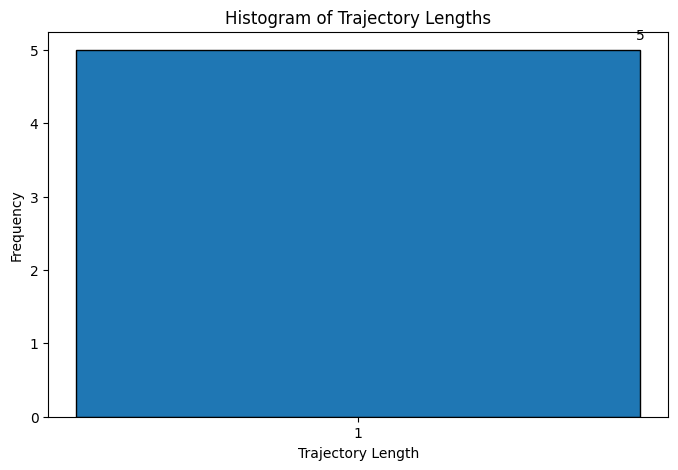

In [15]:
# print("Oolong RLM Evaluation Results:")
# print(f"Split: devset_trec, first {len(current_devset)} examples")
# print(f"  LLM: {dspy.settings.lm.model}")
# print(f"  RLM: {results.score:.4f}")
avg_trajectory_length = sum(len(result[1].trajectory) for result in results.results) / len(results.results)
print(f"  Avg trajectory length: {avg_trajectory_length:.2f}")

import matplotlib.pyplot as plt

# Collect all trajectory lengths
trajectory_lengths = [len(result[1].trajectory) for result in results.results]

plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(
    trajectory_lengths,
    bins=range(1, max(trajectory_lengths) + 2),
    edgecolor='black',
    align='left'
)
plt.xlabel('Trajectory Length')
plt.ylabel('Frequency')
plt.title('Histogram of Trajectory Lengths')
plt.xticks(range(1, max(trajectory_lengths)+1))

# Add counts above each bar
for count, bin_left, patch in zip(counts, bins[:-1], patches):
    if count > 0:
        plt.text(
            bin_left + patch.get_width() / 2,
            count + 0.02 * max(counts),  # A little above the bar
            f"{int(count)}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()



## Inspect a Single Trajectory

Let's run RLM on one example and examine the trajectory (the sequence of code executions).

In [ ]:
# for i, ex in enumerate(current_devset):
    #   print(f"{i}: context_len={ex.context_len:,} tokens")

0: context_len=131,072 tokens
1: context_len=32,768 tokens
2: context_len=2,048 tokens
3: context_len=1,024 tokens
4: context_len=262,144 tokens
5: context_len=16,384 tokens
6: context_len=262,144 tokens
7: context_len=16,384 tokens
8: context_len=4,194,304 tokens
9: context_len=65,536 tokens
10: context_len=4,096 tokens
11: context_len=8,192 tokens
12: context_len=65,536 tokens
13: context_len=524,288 tokens
14: context_len=2,048 tokens
15: context_len=2,048 tokens
16: context_len=524,288 tokens
17: context_len=262,144 tokens
18: context_len=8,192 tokens
19: context_len=1,024 tokens
20: context_len=65,536 tokens
21: context_len=4,096 tokens
22: context_len=2,097,152 tokens
23: context_len=8,192 tokens
24: context_len=4,194,304 tokens
25: context_len=65,536 tokens
26: context_len=131,072 tokens
27: context_len=2,048 tokens
28: context_len=131,072 tokens
29: context_len=4,194,304 tokens
30: context_len=2,048 tokens
31: context_len=4,096 tokens
32: context_len=524,288 tokens
33: context_

In [13]:
example = current_devset[8]
print(example.context_len)

def print_trajectory(trajectory):
    """Pretty-print an RLM trajectory."""
    for i, step in enumerate(trajectory):
        print(f"\n{'='*60}")
        print(f"Step {i+1}")
        print(f"{'='*60}")
        
        if step.get("reasoning"):
            reasoning = step['reasoning']
            print(f"\nReasoning: {reasoning}")
        
        print(f"\nCode:")
        print(f"```python")
        print(step["code"])
        print(f"```")
        
        print(f"\nOutput:")
        output = step["output"]
        if len(output) > 500:
            print(output[:500] + "\n... (truncated)")
        else:
            print(output if output else "(no output)")

print(f"Query: {example.query}")
print(f"Expected: {example.answer}")
print(f"Context length: {len(example.context):,} chars, First 100 chars: {example.context[:100]}")
print("\nRunning RLM...")

gpt5 = dspy.LM("openai/gpt-5")
dspy.configure(lm=gpt5)

from dspy.predict.rlm import RLM

rlm = RLM("context, query -> answer", max_iterations=10, verbose=True)

result = rlm(context=example.context, query=example.query)

print_trajectory(result.trajectory)

2026/01/06 22:29:46 INFO dspy.predict.rlm: RLM iteration 1/10
2026/01/06 22:29:47 INFO dspy.predict.rlm: Reasoning: STEP 1 - EXPLORE: I will inspect the structure of `context`, print its length, show a small head sam...


4194304
Query: In the above data, is label 'location' more common, less common, or the same frequency as label 'human being'? Give your final answer in the form 'Answer: location is [X] human being', where [X] is 'more common than', 'less common than', or 'same frequency as'.
Expected: ['more common than']
Context length: 9,874,323 chars, First 100 chars: The following lines contain 102158 general-knowledge questions, one per line. Each question has an a

Running RLM...


2026/01/06 22:29:48 INFO dspy.predict.rlm: Executed code, output: Type of context: str
Length of context: 9874323
Preview of first 1000 chars:
 The following lines contain 102158 general-knowledge questions, one per line. Each question has an answer that can be desc...
2026/01/06 22:29:48 INFO dspy.predict.rlm: RLM iteration 2/10
2026/01/06 22:29:48 INFO dspy.predict.rlm: Reasoning: STEP 2 - ANALYZE: I will search the context to locate how labels are encoded per line (e.g., "|| Lab...
2026/01/06 22:29:49 INFO dspy.predict.rlm: Executed code, output: Data starts at line index: 4
Total data lines (raw): 102162
Found 'Label:' occurrences in first 5000 data lines: 0
Sample 'Label:' lines (last 200 chars and captured label): []
Found bracket tag occur...
2026/01/06 22:29:49 INFO dspy.predict.rlm: RLM iteration 3/10
2026/01/06 22:29:49 INFO dspy.predict.rlm: Reasoning: What I know:
- context is a very large string (~9.87M chars) with 102,158 question lines after a bri...
2026/01/06 22:29:54 


Step 1

Reasoning: STEP 1 - EXPLORE: I will inspect the structure of `context`, print its length, show a small head sample of the raw text, and print the first few lines to understand the line format and how labels are encoded. I will not compute or answer yet.

Code:
```python
# STEP 1 - EXPLORE
print("Type of context:", type(context).__name__)
print("Length of context:", len(context))
print("Preview of first 1000 chars:\n", context[:1000])

# Show the first 40 lines (truncated per line) to inspect formatting
lines = context.splitlines()
print("\nNumber of lines (including header and data):", len(lines))
for i, line in enumerate(lines[:40]):
    print(f"{i:02d}: {repr(line[:200])}")

print("\nQuery:", query)

# Note: Not answering yet; only exploring.
```

Output:
Type of context: str
Length of context: 9874323
Preview of first 1000 chars:
 The following lines contain 102158 general-knowledge questions, one per line. Each question has an answer that can be described as one of 6 categ

## Visualize the Trajectory

The trajectory shows each iteration: the code executed and the output received.

In [ ]:


# print_trajectory(result.trajectory)

## When to Use RLM

RLM is particularly useful when:

1. **Long contexts**: The context is too large to fit in the LLM's context window, or would be expensive to process directly
2. **Aggregation tasks**: You need to count, compare, or aggregate information across a large document
3. **Structured data**: The context has structure (JSON, tables, sections) that can be programmatically navigated
4. **Iterative exploration**: The answer requires examining the data from multiple angles

The key insight is that LLMs can write code to efficiently process data, calling back to sub-LLMs only when semantic understanding is needed.